<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 6
<br>
<b>Deadline:</b> March 24, 2021 (Wednesday) 23:00
</div>

# Exercise 4.2 Recommender system

In this exercise, your task is to design a recommender system.

## Learning goals:
* Practise tuning a neural network model by using different regularization methods.

In [381]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tools
import data

In [382]:
skip_training = False  # Set this flag to True before validation and submission

In [383]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [384]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [385]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [386]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Ratings dataset

We will train the recommender system on the dataset in which element consists of three values:
* `user_id` - id of the user (the smallest user id is 1)
* `item_id` - id of the movie (the smallest item id is 1)
* `rating` - rating given by the user to the item (ratings are integer numbers between 1 and 5.

The recommender system need to predict the rating for any given pair of `user_id` and `item_id`.

We measure the quality of the predicted ratings using the mean-squared error (MSE) loss:
$$
  \frac{1}{N}\sum_{i=1}^N (r_i - \hat{r}_i)^2
$$
where $r_i$ is a real rating and $\hat{r}_i$ is a predicted one.

Note: The predicted rating $\hat{r}_i$ does not have to be an integer number.

In [387]:
trainset = data.RatingsData(root=data_dir, train=True)
testset = data.RatingsData(root=data_dir, train=False)

In [388]:
# Print one sample from the dataset
x = trainset[0]
print(f'user_id={x[0]}, item_id={x[1]}, rating={x[2]}')

user_id=1, item_id=1, rating=5


# Model

You need to design a recommender system model with the API described in the cell below.

Hints on the model architecture:
* You need to use [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding) layer to convert inputs `user_ids` and `item_ids` into reasonable representations. The idea of the embedding layer is that we want to represent similar users with values that are close to each other. The original representation as integers is not good for that. By using the embedding layer, we can learn such useful representations automatically.

### Model tuning

In this exercise, you need to tune the architecture of your model to achieve the best performance on the provided test set. You will notice that overfitting is a severe problem for this data: The model can easily overfit the training set producing poor accuracy on the out-of-training (test) data.

You need to find an optimal combination of the hyperparameters, with some hyperparameters corresponding to the regularization techniques that we studied in the lecture.

The hyperparameters that you are advised to consider:
* Learning rate value and learning rate schedule (decresing the learning rate often has positive effect on the model performance)
* Number of training epochs
* Network size
* Weight decay
* Early stopping
* Dropout
* Increase amount of data:
  * Data augmentation
  * Injecting noise

You can tune the hyperparameters by, for example, grid search, random search or manual tuning.

Note:
* The number of points that you will get from this exercise depends on the MSE loss on the test set:
  * below 1.00: 1 point
  * below 0.95: 2 points
  * below 0.92: 3 points
  * below 0.90: 4 points
  * below 0.89: 5 points
  * below 0.88: 6 points 

In [389]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('user_id')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:n]

    movie_groups = ratings.groupby('movie_id')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:n]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='user_id').
        join(top_movies, rsuffix='_r', how='inner', on='movie_id'))

    return pd.crosstab(top.user_id, top.movie_id, top.rating, aggfunc=np.sum)

ratings = pd.DataFrame({'user_id': trainset[:][0], 'movie_id': trainset[:][1], 'rating': trainset[:][2]})
tabular_preview(ratings)

movie_id,1,7,50,56,98,100,121,127,174,181,258,286,288,294,300
user_id,,,,,,,,,,,,,,,
7,NaN,5.0,NaN,5.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,4.0,1.0,4.0
13,3.0,2.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,1.0,2.0,1.0
94,4.0,4.0,5.0,5.0,4.0,5.0,2.0,NaN,4.0,4.0,5.0,4.0,3.0,NaN,NaN
181,3.0,4.0,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,3.0,1.0,4.0,2.0,3.0
234,3.0,2.0,4.0,3.0,4.0,4.0,NaN,NaN,3.0,3.0,NaN,3.0,3.0,3.0,3.0
276,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,NaN,4.0,4.0,NaN
279,3.0,NaN,3.0,4.0,NaN,4.0,4.0,NaN,4.0,3.0,NaN,NaN,3.0,2.0,NaN
303,5.0,NaN,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0
308,4.0,4.0,5.0,5.0,3.0,5.0,NaN,4.0,4.0,4.0,NaN,NaN,4.0,3.0,NaN


In [390]:
class RecommenderSystem(nn.Module):
    def __init__(self, n_users, n_items):
        """
        Args:
          n_users: Number of users.
          n_items: Number of items.
        """
        super(RecommenderSystem, self).__init__()
        
        n_factors = 150
        p = [0.02, 0.2, 0.25]
        
        self.users = nn.Embedding(n_users + 1, n_factors)
        self.movies = nn.Embedding(n_items + 1, n_factors)
        self.embedding_drop = nn.Dropout(p=p[0])
        
        self.features = nn.Sequential(
            nn.Linear(2 * n_factors, 100, bias=True),
            nn.ReLU(),
            nn.Dropout(p=p[1]),
            nn.Linear(100, 200, bias=True),
            nn.ReLU(),
            nn.Dropout(p=p[2]),
            nn.Linear(200, 300, bias=True),
            nn.ReLU(),
        )
        self.fc = nn.Linear(300, 1)
        
    def forward(self, user_ids, item_ids):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).
        
        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        features = torch.cat([self.users(user_ids), self.movies(item_ids)], dim=1)
        x = self.embedding_drop(features)
        x = self.features(x)
        out = self.fc(x)
        
        return torch.squeeze(out)


You can test the shapes of the model outputs using the function below.

In [391]:
def test_RecommenderSystem_shapes():
    n_users, n_items = 100, 1000
    model = RecommenderSystem(n_users, n_items)
    batch_size = 10
    user_ids = torch.arange(1, batch_size+1)
    item_ids = torch.arange(1, batch_size+1)
    output = model(user_ids, item_ids)
    print(output.shape)
    assert output.shape == torch.Size([batch_size]), "Wrong output shape."
    print('Success')

test_RecommenderSystem_shapes()

torch.Size([10])
Success


In [392]:
# This cell is reserved for testing

## Train the model

You need to train a recommender system using **only the training data.** Please use the test set to select the best model: the model that generalizes best to out-of-training data.

In [393]:
# Create the model
model = RecommenderSystem(trainset.n_users, trainset.n_items)

In [394]:
import copy
#print(model)
# training loop parameters
lr = 0.01
wd = 0.001
gamma = 1.0
batch_size = 32
epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

train_set_len = len(trainset)
test_set_len = len(testset)
train_iterations = len(trainloader)
test_iterations = len(testloader)

if not skip_training:
    model.zero_grad()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, cycle_momentum=False, base_lr=lr, max_lr=lr/10, step_size_up=train_iterations, gamma=gamma)

    for epoch in range(epochs):
        stats = {'epoch': epoch + 1, 'total': epochs}
        
        for phase in ("train", "test"):
            if (phase == "train"):
                model.train()
                training = True
            else:
                model.eval()
                training = False
            loader = trainloader if training else testloader
            set_length = train_set_len if training else test_set_len
            
            running_loss = 0
            for batch_num, training_batch in enumerate(loader):
                users, movies, ratings = training_batch
                users, movies, ratings = torch.autograd.Variable(users), torch.autograd.Variable(movies), torch.autograd.Variable(ratings).to(torch.float32)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(training):
                    output = model(users, movies)
                    loss = criterion(output, ratings)
                    if training:
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        lr_history.extend(scheduler.get_last_lr())

                running_loss += loss.item()
            epoch_loss = running_loss / set_length
            stats[phase] = epoch_loss
            
            if phase == 'test':
                if epoch_loss < best_loss:
                    print(f"loss improvement @{epoch + 1}")
                    best_loss = epoch_loss
                    best_weights = copy.deepcopy(model.state_dict())
                    no_improvements = 0
                else:
                    no_improvements += 1

        history.append(stats)
        print("{epoch}/{total} train: {train} - validate: {test}".format(**stats))
        
        if no_improvements >= patience:
            print("early stop @{epoch}".format(**stats))
            break

    model.eval()
    model.load_state_dict(best_weights)
    print("Done")
    
# This is the function to compute the loss:
def compute_loss(mlp, x1, x2, y):
    mlp.eval()
    with torch.no_grad():
        outputs = mlp.forward(x1, x2)
        loss = F.mse_loss(outputs, y)
        return loss.cpu().numpy()


train_loss = compute_loss(model, trainset[:][0], trainset[:][1], trainset[:][2])
test_loss = compute_loss(model, testset[:][0], testset[:][1], testset[:][2])
print(f"Train loss: {train_loss}")
print(f"Test loss: {test_loss}")

loss improvement @1
1/100 train: 0.035213037407025694 - validate: 0.028808431658148767
2/100 train: 0.03137863519228995 - validate: 0.0326986135661602
loss improvement @3
3/100 train: 0.030815788387134672 - validate: 0.028115556219220163
4/100 train: 0.03024483872875571 - validate: 0.03532012806087732
loss improvement @5
5/100 train: 0.030100154036283494 - validate: 0.02789440435022116
6/100 train: 0.03002560737654567 - validate: 0.03101680243164301
loss improvement @7
7/100 train: 0.029944178909808397 - validate: 0.027889008851349355
8/100 train: 0.02961565770469606 - validate: 0.030814530447125434
loss improvement @9
9/100 train: 0.029822149670496585 - validate: 0.02769781206101179
10/100 train: 0.02949757703952491 - validate: 0.029998143157362937
11/100 train: 0.029715153421089054 - validate: 0.028161324493587016
12/100 train: 0.029647328954935073 - validate: 0.031053162325918676
13/100 train: 0.02975340770855546 - validate: 0.028228915032744408
14/100 train: 0.029476657905429603 - 

<AxesSubplot:xlabel='epoch'>

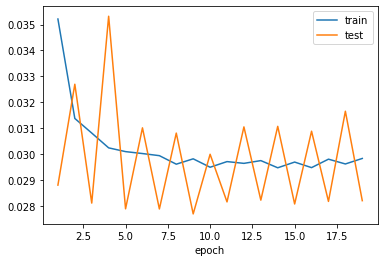

In [395]:
pd.DataFrame(history).drop(columns='total').plot(x='epoch')

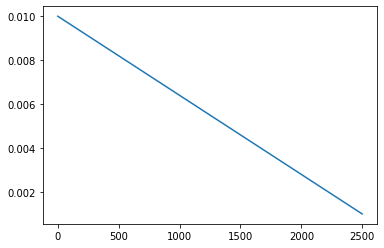

In [396]:
plt.plot(lr_history[:train_iterations])

In [397]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(model, 'recsys.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to recsys.pth.


In [398]:
if skip_training:
    model = RecommenderSystem(trainset.n_users, trainset.n_items)
    tools.load_model(model, 'recsys.pth', device)

In [399]:
# This cell is reserved for grading

In [400]:
# This cell is reserved for grading

In [401]:
# This cell is reserved for grading

In [402]:
# This cell is reserved for grading

In [403]:
# This cell is reserved for grading

In [404]:
# This cell is reserved for grading

In [405]:
# This cell is reserved for grading